In [1]:
import datetime #to get year 
import numpy as np  #to handle arrays
import pandas as pd #to work with datasets

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split  #ml models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from xgboost import XGBRegressor

In [2]:
dataset = pd.read_csv("dataset.csv")
dataset.head(5)

,Unnamed: 0,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price
0,0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,1.75
1,1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,12.50
2,2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,4.50
3,3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,6.00
4,4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,17.74


In [3]:
X_train, X_test, y_train, y_test = train_test_split(dataset.iloc[:, :-1], 
                                                    dataset.iloc[:, -1], 
                                                    test_size = 0.3, 
                                                    random_state = 42) #splitting dataset into train and test

In [4]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4213 entries, 4201 to 860
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         4213 non-null   int64  
 1   Name               4213 non-null   object 
 2   Location           4213 non-null   object 
 3   Year               4213 non-null   int64  
 4   Kilometers_Driven  4213 non-null   int64  
 5   Fuel_Type          4213 non-null   object 
 6   Transmission       4213 non-null   object 
 7   Owner_Type         4213 non-null   object 
 8   Mileage            4212 non-null   object 
 9   Engine             4189 non-null   object 
 10  Power              4189 non-null   object 
 11  Seats              4185 non-null   float64
dtypes: float64(1), int64(3), object(8)
memory usage: 427.9+ KB


In [5]:
X_train = X_train.iloc[:, 1:] # 1. removing index
X_test = X_test.iloc[:, 1:]

In [6]:
X_train["Name"].value_counts()

Name
Mahindra XUV500 W8 2WD                        35
Maruti Swift VDI                              31
Maruti Ritz VDi                               26
Hyundai i10 Sportz                            25
Maruti Swift Dzire VDI                        24
                                              ..
Toyota Innova 2.5 EV Diesel MS 8 Str BSIII     1
Maruti Swift RS VDI                            1
Maruti Wagon R VXI Minor ABS                   1
Skoda Laura Ambition 2.0 TDI CR MT             1
Hyundai i20 Asta (o)                           1
Name: count, Length: 1592, dtype: int64

In [8]:
make_train = X_train["Name"].str.split(" ", expand = True) #getting only the manufacturerer name from the full name
make_test = X_test["Name"].str.split(" ", expand = True)
X_train["Manufacturer"] = make_train[0]
X_test["Manufacturer"] = make_test[0]

Text(0, 0.5, 'Count of cars')

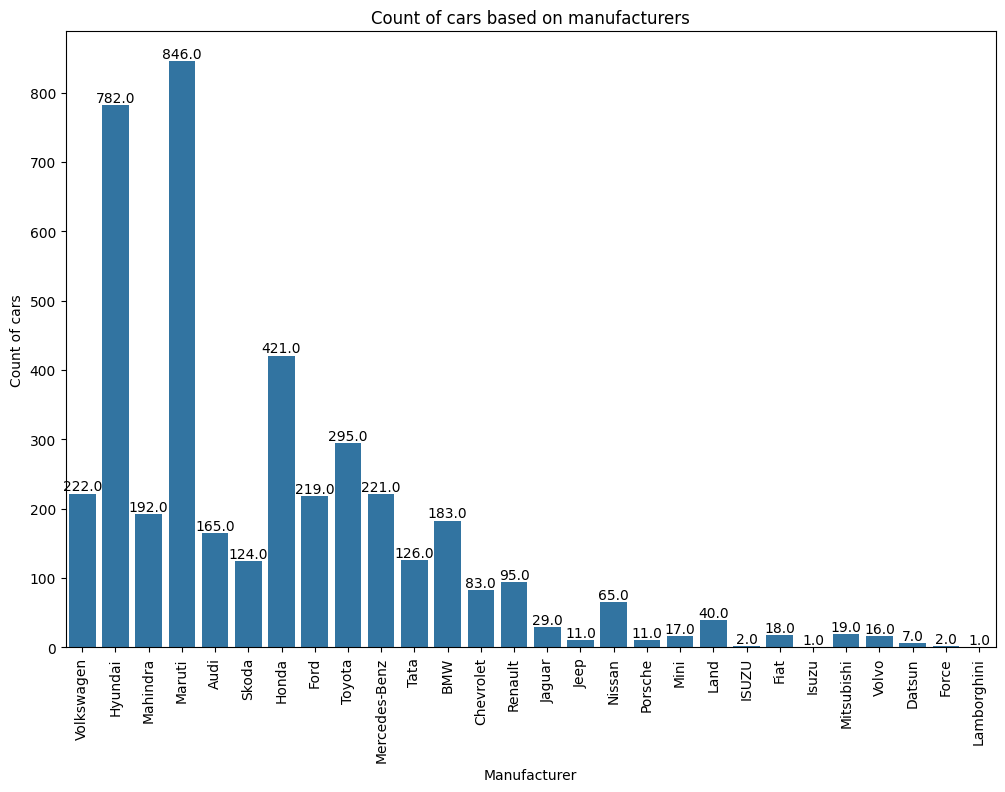

In [9]:
plt.figure(figsize = (12, 8))
plot = sns.countplot(x = 'Manufacturer', data = X_train)
plt.xticks(rotation = 90)
for p in plot.patches:
    plot.annotate(p.get_height(), 
                        (p.get_x() + p.get_width() / 2.0, 
                         p.get_height()), 
                        ha = 'center', 
                        va = 'center', 
                        xytext = (0, 5),
                        textcoords = 'offset points')

plt.title("Count of cars based on manufacturers")
plt.xlabel("Manufacturer")
plt.ylabel("Count of cars")

Maximum cars in the dataset are by the manufacturer **Maruti** and there are no null values.

I'll also drop the `Name` column.

In [10]:
X_train.drop("Name", axis = 1, inplace = True)
X_test.drop("Name", axis = 1, inplace = True)

### Location

Location should not be a determinant for the price of a car and I'll safely remove it.

In [11]:
X_train.drop("Location", axis = 1, inplace = True)
X_test.drop("Location", axis = 1, inplace = True)

### Year

Year has no significance on its own unless we try to extract how old a car is from this and see how its resale price may get affected.

In [12]:
curr_time = datetime.datetime.now()
X_train['Year'] = X_train['Year'].apply(lambda x : curr_time.year - x)
X_test['Year'] = X_test['Year'].apply(lambda x : curr_time.year - x)

### Fuel_Type, Transmission,  and Owner_Type

All these columns are categorical columns which should be converted to dummy variables before being used.

### Kilometers_Driven

`Kilometers_Driven` is a numerical column with a certain range of values.

In [13]:
X_train["Kilometers_Driven"]

4201     77000
4383     19947
1779     70963
4020    115195
3248     58752
         ...  
3772     27000
5191      9000
5226    140000
5390     76414
860      98000
Name: Kilometers_Driven, Length: 4213, dtype: int64

The data range is really varied and the high values might affect prediction, thus, it is really important that scaling be applied to this column for sure.

## Mileage

This column defines the mileage of the car. We need to extract the numerical value out of each string and save it.

In [14]:
mileage_train = X_train["Mileage"].str.split(" ", expand = True)
mileage_test = X_test["Mileage"].str.split(" ", expand = True)

X_train["Mileage"] = pd.to_numeric(mileage_train[0], errors = 'coerce')
X_test["Mileage"] = pd.to_numeric(mileage_test[0], errors = 'coerce')

Let's check for missing values.

In [15]:
print(sum(X_train["Mileage"].isnull()))
print(sum(X_test["Mileage"].isnull()))

1
1


There is one missing value in each. I'll replace the missing value with the mean value of the column based on the training data.

In [16]:
X_train["Mileage"].fillna(X_train["Mileage"].astype("float64").mean(), inplace = True)
X_test["Mileage"].fillna(X_train["Mileage"].astype("float64").mean(), inplace = True)

/var/folders/qs/77tjmrtx58b6m8531j9c4d3r0000gp/T/ipykernel_84230/852540802.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train["Mileage"].fillna(X_train["Mileage"].astype("float64").mean(), inplace = True)
/var/folders/qs/77tjmrtx58b6m8531j9c4d3r0000gp/T/ipykernel_84230/852540802.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object

### Engine, Power and Seats

The `Engine` values are defined in CC so I need to remove `CC` from the data. Similarly, `Power` has bhp, so I'll remove `bhp` from it. Also, as there are missing values in `Engine`, `Power` and `Seats`, I'll again replace them with the mean.

In [17]:
cc_train = X_train["Engine"].str.split(" ", expand = True)
cc_test = X_test["Engine"].str.split(" ", expand = True)
X_train["Engine"] = pd.to_numeric(cc_train[0], errors = 'coerce')
X_test["Engine"] = pd.to_numeric(cc_test[0], errors = 'coerce')

bhp_train = X_train["Power"].str.split(" ", expand = True)
bhp_test = X_test["Power"].str.split(" ", expand = True)
X_train["Power"] = pd.to_numeric(bhp_train[0], errors = 'coerce')
X_test["Power"] = pd.to_numeric(bhp_test[0], errors = 'coerce')

In [18]:
X_train["Engine"].fillna(X_train["Engine"].astype("float64").mean(), inplace = True)
X_test["Engine"].fillna(X_train["Engine"].astype("float64").mean(), inplace = True)

X_train["Power"].fillna(X_train["Power"].astype("float64").mean(), inplace = True)
X_test["Power"].fillna(X_train["Power"].astype("float64").mean(), inplace = True)

X_train["Seats"].fillna(X_train["Seats"].astype("float64").mean(), inplace = True)
X_test["Seats"].fillna(X_train["Seats"].astype("float64").mean(), inplace = True)

/var/folders/qs/77tjmrtx58b6m8531j9c4d3r0000gp/T/ipykernel_84230/878791547.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train["Engine"].fillna(X_train["Engine"].astype("float64").mean(), inplace = True)
/var/folders/qs/77tjmrtx58b6m8531j9c4d3r0000gp/T/ipykernel_84230/878791547.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object o

## Data Processing

Now that we have worked with the training data, let's create dummy columns for categorical columns before we begin training.

In [20]:
X_train = pd.get_dummies(X_train,
                         columns = ["Manufacturer", "Fuel_Type", "Transmission", "Owner_Type"],
                         drop_first = True)

In [21]:
X_test = pd.get_dummies(X_test,
                         columns = ["Manufacturer", "Fuel_Type", "Transmission", "Owner_Type"],
                         drop_first = True)

It might be possible that the dummy column creation would be different in test and train data, thus, I'd fill in all missing columns with zeros.

In [22]:
missing_cols = set(X_train.columns) - set(X_test.columns)
for col in missing_cols:
    X_test[col] = 0
X_test = X_test[X_train.columns]

Finally, as the last step of data processing, I'll scale the data.

In [23]:
standardScaler = StandardScaler()
standardScaler.fit(X_train)
X_train = standardScaler.transform(X_train)
X_test = standardScaler.transform(X_test)

## Training and predicting

I'll create a **Linear Regression** model and a **Random Forest** model to train on the data and use it for future predictions.

In [32]:
linearRegression = LinearRegression()
linearRegression.fit(X_train, y_train)
y_pred = linearRegression.predict(X_test)
r2_lr= r2_score(y_test, y_pred)
print(r2_lr)

0.7008908549416735


In [33]:
rf = RandomForestRegressor(n_estimators = 100)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
r2_rf= r2_score(y_test, y_pred)
print(r2_rf)

0.8858295194372509


In [34]:
gbr = GradientBoostingRegressor(n_estimators=100, random_state=42)
gbr.fit(X_train, y_train)
y_pred_gbr = gbr.predict(X_test)
r2_gbr = r2_score(y_test, y_pred_gbr)
print(r2_gbr)

0.873018760787887


In [35]:
xgb = XGBRegressor(n_estimators=100, random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
r2_xgb = r2_score(y_test, y_pred_xgb)
print(r2_xgb)

0.872725165186868


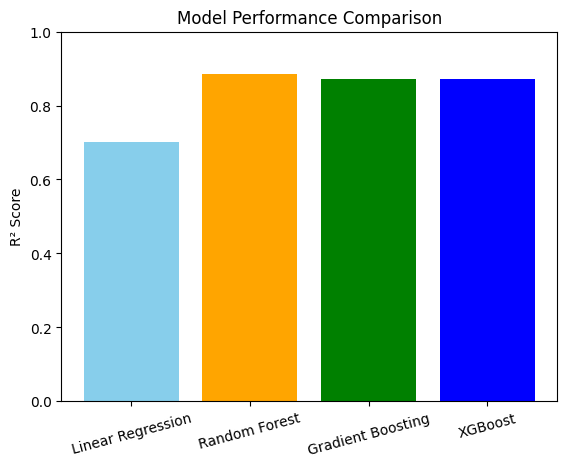

In [36]:
models = ['Linear Regression', 'Random Forest', 'Gradient Boosting', 'XGBoost']
scores = [r2_lr, r2_rf, r2_gbr, r2_xgb]

plt.bar(models, scores, color=['skyblue', 'orange', 'green', 'blue'])
plt.ylabel('R² Score')
plt.title('Model Performance Comparison')
plt.ylim(0, 1) 
plt.xticks(rotation=15)
plt.show()

The **Random Forest** model performed the best with a R2 score of **0.885**.